# Ginkgo clustering environment

## Setup

In [ ]:
%matplotlib inline

import sys
import os
import numpy as np
from matplotlib import pyplot as plt
import gym
import logging
from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
from stable_baselines.deepq import MlpPolicy as DQNMlpPolicy
from stable_baselines import PPO2, ACER, DQN
from stable_baselines.bench import Monitor
from stable_baselines import results_plotter
from stable_baselines.common.env_checker import check_env

sys.path.append("../")
from ginkgo_rl import GinkgoLikelihoodEnv, GinkgoLikelihood1DEnv, GinkgoLikelihoodShuffledEnv


In [ ]:
# Logging setup
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

for key in logging.Logger.manager.loggerDict:
    if "ginkgo_rl" not in key:
        logging.getLogger(key).setLevel(logging.ERROR)
        
def set_output(on=True):
    for key in logging.Logger.manager.loggerDict:
        if "ginkgo_rl" in key:
            logging.getLogger(key).setLevel(logging.DEBUG if on else logging.ERROR)


## Let's play a round of clustering manually

In [3]:
set_output(True)
env = gym.make("GinkgoLikelihoodShuffled-v0")
state = env.reset()
env.render()

15:58 ginkgo_rl.envs.ginkg DEBUG   Initializing environment
15:58 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 6 leaves
15:58 ginkgo_rl.envs.ginkg DEBUG   Resetting environment
15:58 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 8 leaves
15:58 ginkgo_rl.envs.ginkg INFO    8 particles:
15:58 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  0.5,   0.3,   0.2,   0.3)
15:58 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  0.7,   0.5,   0.3,   0.4)
15:58 ginkgo_rl.envs.ginkg INFO      p[ 4] = (  0.3,   0.1,   0.2,   0.2)
15:58 ginkgo_rl.envs.ginkg INFO      p[ 5] = (  0.2,   0.1,   0.1,   0.1)
15:58 ginkgo_rl.envs.ginkg INFO      p[ 6] = (  0.6,   0.4,   0.3,   0.3)
15:58 ginkgo_rl.envs.ginkg INFO      p[ 7] = (  0.2,   0.1,   0.1,   0.1)
15:58 ginkgo_rl.envs.ginkg INFO      p[ 8] = (  0.1,   0.0,   0.1,   0.0)
15:58 ginkgo_rl.envs.ginkg INFO      p[ 9] = (  1.5,   0.7,   1.0,   0.8)


In [6]:
state

array([[ 0.34696613,  0.13362746,  0.24701756,  0.20369778],
       [-1.        , -1.        , -1.        , -1.        ],
       [ 0.56825371,  0.41477329,  0.25535742,  0.29204265],
       [ 0.50437116,  0.33480547,  0.18616926,  0.32725689],
       [ 1.4725264 ,  0.65806627,  1.03171511,  0.8190164 ],
       [ 0.92836403,  0.62958616,  0.42267241,  0.5332205 ],
       [-1.        , -1.        , -1.        , -1.        ],
       [ 0.07593368,  0.0347257 ,  0.05142094,  0.04032181],
       [ 0.18280068,  0.10381683,  0.11504847,  0.09384515],
       [-1.        , -1.        , -1.        , -1.        ]])

In [9]:
# Merge two particles
action = 3, 7

state, reward, done, info = env.step(action)
env.render()

print(f"Reward: {reward}")
print(f"Done: {done}")
print(f"Info: {info}")

# Repeat this cell as often as you feel like


15:59 ginkgo_rl.envs.ginkg DEBUG   Environment step. Action: (2, 4)
15:59 ginkgo_rl.envs.ginkg DEBUG   Computing log likelihood of action (2, 4): -15.332371711730957
15:59 ginkgo_rl.envs.ginkg DEBUG   Merging particles 2 and 4. New state has 5 particles.
15:59 ginkgo_rl.envs.ginkg INFO    5 particles:
15:59 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  2.0,   1.1,   1.3,   1.1)
15:59 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  0.3,   0.1,   0.2,   0.2)
15:59 ginkgo_rl.envs.ginkg INFO      p[ 6] = (  0.2,   0.1,   0.1,   0.1)
15:59 ginkgo_rl.envs.ginkg INFO      p[ 7] = (  0.9,   0.6,   0.4,   0.5)
15:59 ginkgo_rl.envs.ginkg INFO      p[ 8] = (  0.6,   0.4,   0.2,   0.4)


Reward: -15.332371711730957
Done: False
Info: {'legal': True, 'illegal_action_counter': 0, 'replace_illegal_action': False, 'i': 2, 'j': 4}


In [10]:
env.close()

## Env checker

In [12]:
set_output(False)
env = gym.make("GinkgoLikelihoodShuffled-v0")

check_env(env)

for i in range(env.n_max):
    assert i == env.inverse_permutation[env.permutation[i]] == env.permutation[env.inverse_permutation[i]]
    
env.close()

/Users/johannbrehmer/anaconda3/envs/rl/lib/python3.7/site-packages/stable_baselines/common/env_checker.py:202: UserWarning: Your observation has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector
  warnings.warn("Your observation has an unconventional shape (neither an image, nor a 1D vector). "


------------------------------


/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


## Reward distribution for random actions

In [13]:
n_steps = 4000

set_output(False)
env = gym.make("GinkgoLikelihoodShuffled-v0")
state = env.reset()
rewards, legal = [], []

for _ in range(n_steps):
    action = env.action_space.sample()
    legal.append(env.check_legality(action))
    _, reward, _, _ = env.step(action)
    rewards.append(reward)


------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------


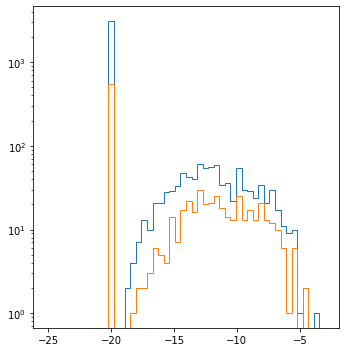

In [14]:
range_ = (-25.1, -3)

rewards = np.asarray(rewards)
legal = np.asarray(legal)

fig = plt.figure(figsize=(5,5))
plt.hist(rewards, range=range_, bins=50, histtype="step")
plt.hist(rewards[legal], range=range_, bins=50, histtype="step")
plt.tight_layout()
plt.yscale("log")
plt.show()


## Let's let some RL agents loose!

In [15]:
log_dirs = []
models = {}
wrap1ds = {}

def train(algorithm, algo_class, policy_class, wrap1d=False, n_steps=100000):
    log_dir = f"./logs/{algorithm}/"
    log_dirs.append(log_dir)

    set_output(False)
    env = gym.make("GinkgoLikelihood1D-v0" if wrap1d else "GinkgoLikelihoodShuffled-v0")
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(env, log_dir)

    model = algo_class(policy_class, env, verbose=0)
    model.learn(total_timesteps=n_steps)
    
    models[algorithm] = model
    wrap1ds[algorithm] = wrap1d
    env.close()


def run(algorithm):
    model = models[algorithm]
    
    set_output(True)
    env = gym.make("GinkgoLikelihood1D-v0" if wrap1ds[algorithm] else "GinkgoLikelihoodShuffled-v0")
    state = env.reset()
    done = False
    steps = 0

    while not done and steps < int(1.e5):
        action, _states = model.predict(state)
        obs, reward, done, info = env.step(action)
        env.render()
        steps += 1
    
    env.close()


## DQN

In [ ]:
model = train("dqn", DQN, DQNMlpPolicy, wrap1d=True)

In [ ]:
run("dqn")

## PPO

In [ ]:
model = train("ppo", PPO2, MlpPolicy)

------------------------------


/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


In [ ]:
run("ppo")

## Results

In [ ]:
results_plotter.plot_results(log_dirs, 1e5, results_plotter.X_TIMESTEPS, "Ginkgo")
